# **Part 1**

We will extract the data from the clustering algorithm, We will use the “Daily and Sports Activity” dataset, which has 19 activities, each sport activity has eight subjects and each subject has 60 segments each segment has 45 features. The dataset has 9120 rows and 45 columns. The dataset is available in the UCI Machine Learning Repository. The dataset is collected from 19 subjects performing 19 different activities. We have 2 ways to convert the data to make it ready for clustering:
1. We can use the means of each segment in the subject to represent the subject in the clustering algorithm.
2. We will flatten the data of the single segment then apply a dimensionality reduction technique such as PCA to reduce the number of features to 45 features to represent the segment in the clustering algorithm.

In [1]:
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

In [2]:
# ./data\a01\p1\s01.txt
def getLabels(filePath):
    filedata = filePath.split('\\')
    dataLabel = filedata[1][1:]
    return int(dataLabel)


In [3]:
def getData(rootDir, extension):
    dataIndex = 0
    MeanDataMatrix = np.zeros((19 * 8 * 60, 45))
    DimRedDataMatrix = np.zeros((19 * 8 * 60, 125 * 45))
    dataLabels = np.zeros(19 * 8 * 60)
    for root, dirs, files in os.walk(rootDir):
        for file in files:
            if file.endswith(extension):
                file_path = os.path.join(root, file)
                dataLabels[dataIndex] = getLabels(file_path)
                content = np.genfromtxt(file_path, delimiter=',')
                MeanDataMatrix[dataIndex] = np.mean(content, axis=0)
                DimRedDataMatrix[dataIndex] = content.flatten()
                dataIndex += 1
    return MeanDataMatrix, DimRedDataMatrix, dataLabels, dataIndex


In [4]:
MeanDataMatrix, DimRedDataMatrix, dataLabels, dataIndex = getData('data', '.txt')
pca = PCA(n_components=45)
DimRedDataMatrix = pca.fit_transform(DimRedDataMatrix)

In [5]:
#we take the fist 48 for training and the rest for testing for each person
trainData = np.zeros((19 * 8 * 48, 45))
testData = np.zeros((19 * 8 * 12, 45))
trainDimData = np.zeros((19 * 8 * 48, 45))
testDimData = np.zeros((19 * 8 * 12, 45))
trainLabels = np.zeros(19 * 8 * 48)
testLabels = np.zeros(19 * 8 * 12)
trainIndex = 0
testIndex = 0
for i in range(19 * 8 * 60):
    if i % 60 < 48:
        trainData[trainIndex] = MeanDataMatrix[i]
        trainDimData[trainIndex] = DimRedDataMatrix[i]
        trainLabels[trainIndex] = dataLabels[i]
        trainIndex += 1
    else:
        testData[testIndex] = MeanDataMatrix[i]
        testDimData[testIndex] = DimRedDataMatrix[i]
        testLabels[testIndex] = dataLabels[i]
        testIndex += 1


# **Part 2**

**Let's implement the K-means algorithm from scratch**

In [6]:


def plot_k_distance_graph(data, k):
    neigh = NearestNeighbors(n_neighbors=k)
    fit = neigh.fit(data)
    distances, indices = fit.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]
    plt.plot(distances)
    for i in range(0, len(distances), 210):
        plt.plot(i, distances[i], 'ro')  # 'ro' creates a red circle
    plt.show()
    return np.mean(distances[6500:6750])

k=45


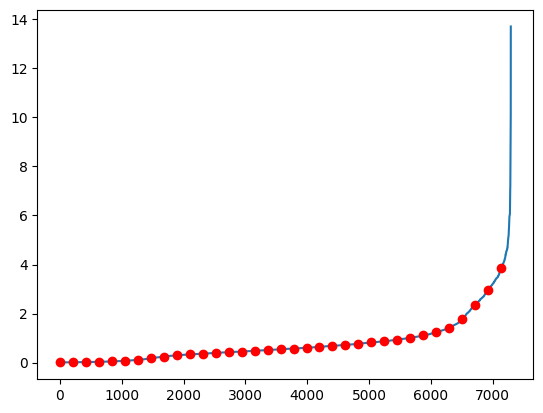

k=67


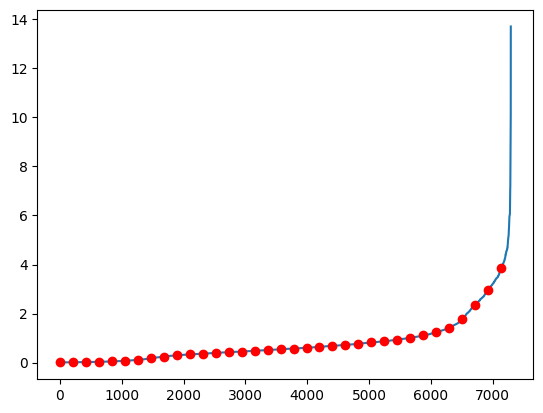

k=90


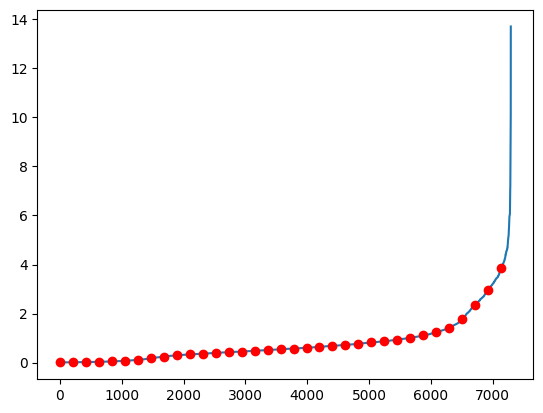

k=45


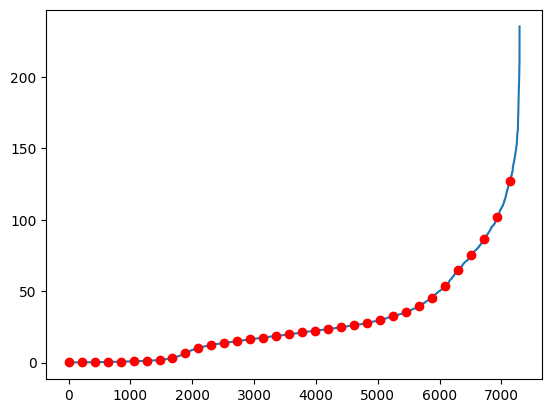

k=67


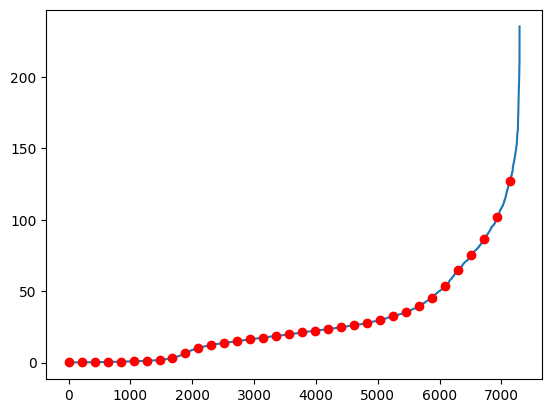

k=90


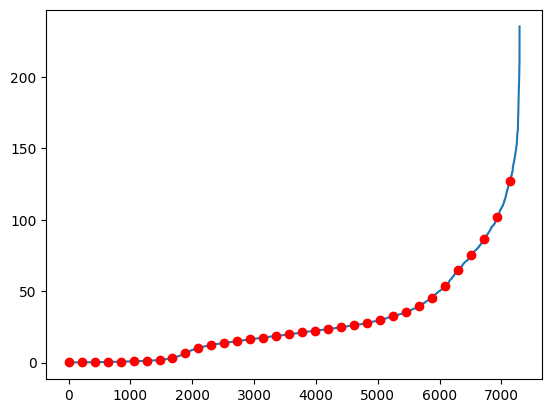

In [7]:
k = [45, 67, 90]
distances = []
for i in k:
    print(f'k={i}')
    distances.append(plot_k_distance_graph(trainData, i))

epsilon1 = np.mean(distances)

for i in k:
    print(f'k={i}')
    distances.append(plot_k_distance_graph(trainDimData, i))

epsilon2 = np.mean(distances)

In [8]:
print(epsilon1)
print(epsilon2)

2.098418771050286
41.5184584866849


let's now implement Kmeans from scratch

In [9]:
# the ecuclidean distance between two vectors
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# the initial centroids are chosen randomly from the dataset
def get_initial_centroids(X, k):
    n_samples, n_features = X.shape
    centroids = np.array([X[np.random.choice(range(n_samples))] for _ in range(k)])
    return centroids

# get the clusters for each centroid by calculating the distance between each sample and the centroids
# then assign the sample to the cluster of the closest centroid
def get_clusters(X, centroids):
    clusters = {i: [] for i in range(len(centroids))}  # initialize the clusters
    for i, sample in enumerate(X):
        centroid_idx = np.argmin(
            [euclidean_distance(sample, centroid) for centroid in centroids])  # Find the closest centroid
        clusters[centroid_idx].append(i)  # append the index of the sample to the cluster
    return clusters


# update the centroids by calculating the mean of the samples in each cluster and assign the new centroid to the mean of the samples
# in the cluster
def update_centroids(X, clusters):
    centroids = np.array([np.mean(X[cluster], axis=0) for cluster in clusters.values()])
    return centroids

# the main function of the Kmeans algorithm that takes the data, the number of clusters, and the maximum number of iterations
# then it returns the centroids and the clusters
def kmeans(X, k, max_iters):
    centroids = get_initial_centroids(X, k)
    clusters = {}
    for _ in range(max_iters):
        clusters = get_clusters(X, centroids)
        prev_centroids = centroids
        centroids = update_centroids(X, clusters)
        if np.all(np.abs(centroids - prev_centroids) < 1e-5):
            break
    return centroids, clusters


def get_majority_label(clusters, train_labels):
    majority_labels_for_cluster = np.zeros(len(clusters))
    for key, cluster in clusters.items():
        labels_in_cluster = train_labels[cluster]
        unique, counts = np.unique(labels_in_cluster, return_counts=True)
        majority_label = unique[np.argmax(counts)]
        majority_labels_for_cluster[key] = majority_label
    return majority_labels_for_cluster

# the predict function that takes the data and the centroids and returns the predicted labels
def predictWithoutMajority(X, centroids):
    predicted_test_labels = np.zeros(X.shape[0])
    for i, sample in enumerate(X):
        centroid_idx = np.argmin([euclidean_distance(sample, centroid) for centroid in centroids])
        predicted_test_labels[i] = centroid_idx
    return predicted_test_labels


def predict(X, centroids, majority_labels_for_clusters):
    predicted_test_labels = np.zeros(X.shape[0])
    for i, sample in enumerate(X):
        centroid_idx = np.argmin([euclidean_distance(sample, centroid) for centroid in centroids])
        predicted_test_labels[i] = majority_labels_for_clusters[centroid_idx]
    return predicted_test_labels

let's train the model on the training data then test it on the testing data

In [10]:
#get the accuracy of Kmeans
def get_accuracy(predicted_labels, true_labels):
    return np.sum(predicted_labels == true_labels) / len(true_labels)

Now we need to evaluate the two methods at different Ks and compare. But first we need to write the evaluation methods.

# **Evaluation Methods**

We need a way to calculate the contingency matrix in order to use it for evaluation because it's going to make it much easier. To do so we need to separate out data points into their predicted labels, and from there we can use the true labels to create the contingency matrix. Therefore, we need a method to create extract the clusters from the predicted labels.

In [11]:
def get_cluster(predictions):
    unique_values = np.unique(predictions)
    clusters = [np.where(predictions == value)[0] for value in unique_values]
    return clusters

Now that we have the clusters we can easily get the contingency matrix.

In [12]:
def get_contingency_matrix(ground_truth, clusters):
    unique_values, counts = np.unique(ground_truth, return_counts=True)
    unique_values = np.array(unique_values, dtype=int)
    temp = np.zeros((len(clusters), max(unique_values) + 1))
    for i in range(len(clusters)):
        unique_values, counts = np.unique(np.array(ground_truth)[clusters[i]], return_counts=True)
        unique_values = np.array(unique_values, dtype=int)
        temp[i][unique_values] = counts
    return temp

Now for the evaluation methods. We need to evaluate the clusters for:
1.   Precision:   Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. Higher precision indicates a high level of exactness or quality of the clustering results.
***
2.  Recall:   Recall (Sensitivity) - the ratio of correctly predicted positive observations to the all observations in actual class. Higher recall indicates the class is correctly recognized by the model.
***
3.  F1 Score:  is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. It is usually more useful than accuracy, especially if you have an uneven class distribution. The F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a clustering Model has a good value for both recall and precision
***
4.  Conditional Entropy:  Conditional entropy measures the amount of information needed to describe the outcome of a random variable given the value of another variable. In the context of clustering, it measures the uncertainty of a cluster given the true labels. Lower conditional entropy indicates better clustering results.



In [13]:
def purity(ground_truth, contingency_matrix):
    return np.sum(np.max(contingency_matrix, axis=1)) / len(ground_truth)

In [14]:
def recall(ground_truth, contingency_matrix):
    max_indices = np.argmax(contingency_matrix, axis=1)
    recall = np.zeros(len(contingency_matrix))

    for i in range(len(contingency_matrix)):
        recall[i] = (contingency_matrix[i, max_indices[i]] / np.sum(contingency_matrix[:, max_indices[i]])) * (
                np.sum(contingency_matrix[i]) / len(ground_truth))

    return np.sum(recall)

In [15]:
import warnings


def conditional_entropy(ground_truth, contingency_matrix):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        Sum = np.sum(contingency_matrix, axis=1)
        log_temp = np.log2((contingency_matrix / Sum.reshape(-1, 1)))
        log_temp[log_temp == -np.inf] = 0
        temp = contingency_matrix * log_temp
        return -np.sum(temp) / len(ground_truth)

In [16]:
def f_measure(contingency_matrix):
    purity = np.max(contingency_matrix, axis=1) / np.sum(contingency_matrix, axis=1)

    # Find the index of the cluster with the maximum count for each ground truth class
    max_indices = np.argmax(contingency_matrix, axis=1)
    recall = np.zeros(len(purity))

    # Calculate recall for each cluster based on the ground truth
    for i in range(len(purity)):
        recall[i] = contingency_matrix[i, max_indices[i]] / np.sum(contingency_matrix[:, max_indices[i]])
    purity = np.reshape(purity, (-1,))
    recall = np.reshape(recall, (-1,))

    return np.sum((2 * purity * recall) / (purity + recall)) / len(purity)

In [17]:
def evaluate_clusters(ground_truth, predictions):
    clusters = get_cluster(predictions)
    contingency = get_contingency_matrix(ground_truth, clusters)
    print("Precision = ", purity(ground_truth, contingency))
    print("Recall = ", recall(ground_truth, contingency))
    print("F1 Score = ", f_measure(contingency))
    print("Conditional Entropy = ", conditional_entropy(ground_truth, contingency))

# **Comparing Kmeans**

In [18]:
k = [8, 13, 19, 28, 38]
max_iters = 1000
for i in k:
    centroids, clusters = kmeans(trainDimData, i, max_iters)
    predictedTestLabels = predictWithoutMajority(testDimData, centroids)
    evaluate_clusters(testLabels, predictedTestLabels)
    print("\n")

Precision =  0.2982456140350877
Recall =  0.8892543859649122
F1 Score =  0.49874123166850626
Conditional Entropy =  2.487181701519231

Precision =  0.40789473684210525
Recall =  0.800438596491228
F1 Score =  0.48426587359574985
Conditional Entropy =  2.1335012555313524

Precision =  0.43475877192982454
Recall =  0.590563322368421
F1 Score =  0.4126858474523029
Conditional Entropy =  2.0429694741208904

Precision =  0.48793859649122806
Recall =  0.4722907529239766
F1 Score =  0.3766463711446565
Conditional Entropy =  1.8398348572932237

Precision =  0.5526315789473685
Recall =  0.42827690972222215
F1 Score =  0.34782900073316814
Conditional Entropy =  1.6082113405060678


In [19]:
for i in k:
    centroids, clusters = kmeans(trainData, i, max_iters)
    predictedTestLabels = predictWithoutMajority(testData, centroids)
    evaluate_clusters(testLabels, predictedTestLabels)
    print("\n")

Precision =  0.2631578947368421
Recall =  0.7035361842105263
F1 Score =  0.392608808450147
Conditional Entropy =  2.5978171327401913

Precision =  0.4100877192982456
Recall =  0.7392521016081871
F1 Score =  0.5156059309149832
Conditional Entropy =  2.1918129481604818

Precision =  0.46326754385964913
Recall =  0.5081894188596491
F1 Score =  0.4598367397025253
Conditional Entropy =  1.8642743527132584

Precision =  0.46326754385964913
Recall =  0.47741913377192985
F1 Score =  0.35682731919201466
Conditional Entropy =  1.8145893377094722

Precision =  0.5882675438596491
Recall =  0.369140625
F1 Score =  0.372595492814661
Conditional Entropy =  1.330194111059229


1. Precision : the precision is higher for the mean data across all cluster sizes. This indicates that the K-means algorithm was more precise when applied to the mean data compared to the PCA reduced data.

***
2. Recall: Recall (Sensitivity) : The recall is higher for the PCA reduced data when the number of clusters is less (8 and 13). However, as the number of clusters increases, the recall for the mean data becomes higher. This suggests that for a smaller number of clusters, the PCA reduced data might be capturing the cluster structure better, but as the number of clusters increases, the mean data provides a better representation.
***
3. F1 Score: the F1 score is higher for the mean data across all cluster sizes. This indicates that the mean data provides a better balance between precision and recall compared to the PCA reduced data.
***
4. Conditional Entropy:  the conditional entropy is lower for the mean data across all cluster sizes. This suggests that the mean data provides a more certain (or less random) clustering result compared to the PCA reduced data.
***
5. Given these results, it appears that mean data provides better overall clustering performance than PCA reduced data for the metrics considered. However, the best choice depends on the specific requirements of your task. If high recall for smaller numbers of clusters is critical, PCA reduced data might be preferable. If overall performance across Precision, Recall, and Conditional Entropy is more important, mean data seems to be the better choice for the K-means algorithm in this case, and  also the PCA may remove information that is valuable for cluster formation. In contrast, using mean data retains more of the original features, which seems to be beneficial for the clustering task in this particular context.


# **Parts 3**

**Part 1**

**Now let's implement Spectral clustering**

In [20]:
from sklearn.cluster import KMeans

In [21]:
def SpectralClustering(D, k, gamma):
    pairwise_sq_dists = np.square(np.linalg.norm(D[:, None] - D, axis=2))
    A = np.exp(-gamma * pairwise_sq_dists)
    delta = np.diag(np.sum(A, axis=1))
    L_a = np.identity(len(A)) - (np.linalg.inv(delta) @ A)
    eig_values, eig_vectors = np.linalg.eigh(L_a)
    sorted_indices = np.argsort(eig_values)

    np.real(eig_values[sorted_indices])
    eig_vectors = np.real(eig_vectors[:, sorted_indices])

    U = eig_vectors[:, :k]
    Y = U / np.linalg.norm(U, axis=1, keepdims=True)

    kmeans = KMeans(n_clusters=k, n_init='auto').fit(Y)
    return kmeans.labels_

**Now it's time to cluster the data. We will also evaluate the clusters simultaneously**

Clustering the data where we took the mean of the columns

In [ ]:
import matplotlib.pyplot as plt
def detected_activities_per_cluster(predictions):
    clusters = get_cluster(predictions)
    counts = [len(cluster) for cluster in clusters]
    plt.bar(range(len(clusters)), counts)
    plt.xlabel('Cluster')
    plt.ylabel('Number of points')
    plt.title('Histogram of Points in Clusters')
    plt.xticks(range(len(clusters)), range(len(clusters)))
    plt.show()

In [22]:
predictions = SpectralClustering(testData, 19, 0.00001)
evaluate_clusters(testLabels, predictions)

Precision =  0.6217105263157895
Recall =  0.6727030793128654
F1 Score =  0.6142484077510811
Conditional Entropy =  1.3053386357030201


Now that the function is implemented we can process to seeing the number of detected activities

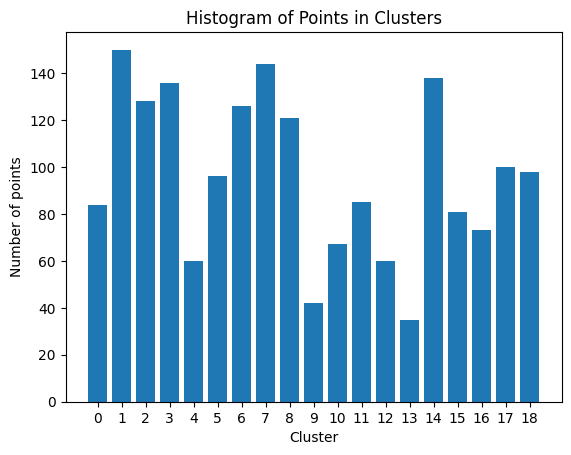

In [24]:
detected_activities_per_cluster(predictions)

Clustering the data where we flattened the features and reduced the dimensions using PCA

In [25]:
predictions = SpectralClustering(testDimData, 19, 0.00001)
evaluate_clusters(testLabels, predictions)

Precision =  0.5630482456140351
Recall =  0.6100717288011697
F1 Score =  0.578098110380351
Conditional Entropy =  1.5664033278872673


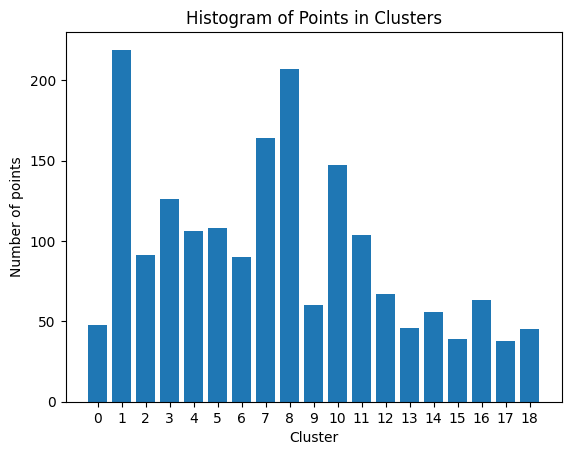

In [26]:
detected_activities_per_cluster(predictions)

We can see that both of them achieved very similar results with some discrepancies which could be due to random initialization of the Kmeans algorithm at the end of the spectral clustering.

**Part 2**

1. Precision: Comparing this to the K-Means algorithm using mean data , the Spectral Clustering algorithm has a higher precision. This indicates that the Spectral Clustering algorithm is more precise in identifying clusters compared to the K-Means algorithm.
***
2. Recall: Comparing this to the K-Means algorithm using mean data , the Spectral Clustering algorithm has a higher recall. This indicates that the Spectral Clustering algorithm is better at capturing the true positive rate of clusters compared to the K-Means algorithm.
***
3. F1 Score: the Spectral Clustering algorithm has a higher F1 score. This indicates that the Spectral Clustering algorithm provides a better balance between precision and recall compared to the K-Means algorithm.
***
4. Conditional Entropy: the conditional entropy for the Spectral Clustering algorithm using mean data is. Comparing this to the K-Means algorithm using mean data , the Spectral Clustering algorithm has a lower (better) conditional entropy.
***
5. summary, the Spectral Clustering algorithm using mean data outperforms the K-Means algorithm using mean data in terms of precision, recall, F1 score, and conditional entropy for the same number of clusters (19). This suggests that the Spectral Clustering algorithm might be a better choice for this specific dataset and task.

1. Precision: Comparing this to the K-Means algorithm using the same data, the Spectral Clustering algorithm has a higher precision.  
***
2. Recall: Recall : Comparing this to the K-Means algorithm using the same data, the K-Means algorithm has a slightly higher recall.  
***
3. F1 Score: Comparing this to the K-Means algorithm using the same data, the Spectral Clustering algorithm has a significantly higher F1 score.  
***
4. Conditional Entropy:Comparing this to the K-Means algorithm using the same data, the Spectral Clustering algorithm has a lower (better) conditional entropy.  
***
5. In summary, the Spectral Clustering algorithm using PCA reduced data outperforms the K-Means algorithm using the same data in terms of precision, F1 score, and conditional entropy for the same number of clusters (19). However, the K-Means algorithm has a slightly higher recall. This suggests that the Spectral Clustering algorithm might be a better choice for this specific dataset and task, depending on the specific requirements of your task. For example, if precision, F1 score, and conditional entropy are more important for your task, you might want to choose the Spectral Clustering algorithm. If recall is more important, you might want to choose the K-Means algorithm.

# **Part 5**

now we will make Agglomerative Clustering algorithm from scratch    

explanation of the algorithm:
1. Start by assigning each data point to its own cluster.
2. Then, compute the distance between each pair of clusters.
3. Merge the two closest clusters.
4. The distance between two clusters can be computed using different methods such as single linkage, complete linkage, and average linkage. a single linkage is the distance between the two closest points in each cluster. complete linkage is the distance between the two farthest points in each cluster. the average linkage is the average distance between all pairs of points in the two clusters which is the most common method, the linkage type is a parameter that the user can choose.
5. Repeat steps 2 and 3 until the desired number of clusters is reached, which is the stopping criterion that determined by the user
6. The final result is the clusters that we get after applying the stopping criterion.


In [27]:
# Single linkage distance for two clusters (minimum distance between two points in the clusters)
def single_linkage_distance(cluster1, cluster2):
    return np.min([euclidean_distance(x1, x2) for x1 in cluster1 for x2 in cluster2])


# Complete linkage distance for two clusters (maximum distance between two points in the clusters)
def complete_linkage_distance(cluster1, cluster2):
    return np.max([euclidean_distance(x1, x2) for x1 in cluster1 for x2 in cluster2])


# Average linkage distance for two clusters (average distance between two points in the clusters)
def average_linkage_distance(cluster1, cluster2):
    return np.mean([euclidean_distance(x1, x2) for x1 in cluster1 for x2 in cluster2])


# Get initial clusters for each point in the dataset (each point is a cluster initially)
def getInitialClusters(X):
    clusters = [[X[i]] for i in range(len(X))]
    numberOfClusters = len(X)
    return clusters, numberOfClusters


def getDistanceMatrix(clusters, linkageType='average'):
    n_clusters = len(clusters)
    distanceMatrix = np.zeros((n_clusters, n_clusters), dtype=float)
    for i in range(n_clusters):
        for j in range(i + 1, n_clusters):
            if linkageType == 'single':
                distance = np.min(pdist(np.vstack([clusters[i], clusters[j]])))
            elif linkageType == 'complete':
                distance = np.max(pdist(np.vstack([clusters[i], clusters[j]])))
            else:
                distance = np.mean(pdist(np.vstack([clusters[i], clusters[j]])))

            distanceMatrix[i, j] = distance
            distanceMatrix[j, i] = distance
    np.fill_diagonal(distanceMatrix, np.inf)
    return distanceMatrix

In [28]:
from scipy.spatial.distance import pdist


def updateDistanceMatrix(distanceMatrix, minIndex, clusters, linkageType):
    clustersNumber = len(clusters)
    for i in range(clustersNumber):
        if i != minIndex[0]:
            if linkageType == 'single':
                distance = np.min(pdist(np.vstack([clusters[minIndex[0]], clusters[i]])))
            elif linkageType == 'complete':
                distance = np.max(pdist(np.vstack([clusters[minIndex[0]], clusters[i]])))
            else:
                distance = np.mean(pdist(np.vstack([clusters[minIndex[0]], clusters[i]])))
            distanceMatrix[minIndex[0], i] = distance
            distanceMatrix[i, minIndex[0]] = distance
    distanceMatrix = np.delete(distanceMatrix, minIndex[1], axis=0)
    distanceMatrix = np.delete(distanceMatrix, minIndex[1], axis=1)
    return distanceMatrix


def agglomerativeClustering(X, numberOfClusters, distanceMatrix, linkageType='average'):
    clusters, clustersNumber = getInitialClusters(X)
    while clustersNumber > numberOfClusters:
        minIndex = np.unravel_index(np.argmin(distanceMatrix, axis=None), distanceMatrix.shape)
        clusters[minIndex[0]] = clusters[minIndex[0]] + clusters[minIndex[1]]
        clusters.pop(minIndex[1])
        clustersNumber -= 1
        distanceMatrix = updateDistanceMatrix(distanceMatrix, minIndex, clusters, linkageType)
    return clusters


let's implement DBSCAN algorithm from scratch
explanation of the algorithm:
 1. initialized all points as unvisited and the labels with zeroes and cluster label zero.

 2. for each point in the dataset, check if the point is visited or not, if not visited, find the neighbors of the point.

 3. if the number of neighbors is less than the minimum number of points, mark the point as noise and continue to the next point.

 4. if the number of neighbors is greater than or equal to the minimum number of points,then we will expand the cluster by assigning the cluster label to the point and expand the cluster by finding the neighbors of the point and assign the cluster label to the neighbors.

 5. while expanding clusters, check if the neighbor is visited or not, if not visited, mark it as visited and find the neighbors of the neighbor and check if the number of neighbors is greater than or equal to the minimum number of points, then expand the cluster by assigning the cluster label to the neighbor and expand the cluster by finding the neighbors of the neighbor and assign the cluster label to the neighbors.

 6. repeat step 4 and 5 until all points are visited.

 7. the final result is the clusters that we get after applying the stopping criterion.

 8. the algorithm has two parameters, epsilon, and minPts. epsilon is the radius of the neighborhood and minPts is the minimum number of points to form a cluster, by default epsilon is 0.5 and minPts is 5 but the user can change them to fit the dataset.

 9. the algorithm is sensitive to the epsilon and minPts parameters, so the user should try different values to get the best results.

advantages of DBSCAN algorithm over K-means:
 1. DBSCAN can find clusters with arbitrary shapes and sizes, while K-means can find only spherical clusters.
 2. DBSCAN can perform really well with noisy data, while K-means is sensitive to noisy data that can affect the performance of the algorithm.
 3. DBSCAN does not require the number of clusters to be specified in advance, while K-means requires the number of clusters to be specified in advance.
 4. DBSCAN is deterministic, while K-means is not deterministic.

disadvantages of DBSCAN algorithm over K-means:
 1. While DBSCAN is great at separating high-density clusters from low-density clusters, DBSCAN struggles with clusters of similar density.
 2. Struggles with high dimensionality data. If given data with too many dimensions, DBSCAN suffers.
 3. it has a high computational cost when the number of data points is large,while K means really faster than DBSCAN.
 4. it is sensitive to the epsilon and minPts parameters, so the user should try different values to get the best results.
 5. it is not suitable for data with varying densities because it uses a single epsilon value for all points in the dataset,wile K means can handle data with varying densities.

In [39]:

def expand_cluster(data_points, point_idx, neighbors, visited, labels, cluster_label, epsilon, minPts):
    labels[point_idx] = cluster_label  # Assign cluster label
    i = 0
    while i < len(neighbors):
        neighbor_idx = neighbors[i]# Get the neighbor
        if neighbor_idx not in visited:# Check if the neighbor is visited
            visited.add(neighbor_idx)# Mark as visited
            neighbor_neighbors = getNeighbours(data_points, neighbor_idx, epsilon)# Find neighbors of the neighbor
            if len(neighbor_neighbors) >= minPts:# Check if the number of neighbors is greater than or equal to minPts
                neighbors += neighbor_neighbors# Expand cluster
        if labels[neighbor_idx] == 0:  # Unassigned
            labels[neighbor_idx] = cluster_label# Assign cluster label
        i += 1

# Get neighbors of a point within epsilon distance from the point
def getNeighbours(data_points, point_idx, epsilon):
    return [i for i in range(data_points.shape[0]) if np.linalg.norm(data_points[point_idx] - data_points[i]) <= epsilon]


def dbscan(data_points, epsilon=0.5, minPts=5):
    labels = np.zeros(data_points.shape[0])  # Initialize cluster labels
    visited = set()  # Track visited points
    cluster_label = 0  # Current cluster label

    for idx in range(data_points.shape[0]):
        if idx not in visited:  # Check if point is already visited
            visited.add(idx)
            neighbors = getNeighbours(data_points, idx, epsilon)  # Find neighbors
            if len(neighbors) < minPts:
                labels[idx] = -1  # Mark as noise
            else:
                cluster_label += 1
                expand_cluster(data_points, idx, neighbors, visited, labels, cluster_label, epsilon, minPts)# Expand cluster from neighbors

    return labels + 1


let's test the DBSCAN algorithm on the dataset mean data

In [143]:
predicted_labels = dbscan(testData, epsilon=epsilon1, minPts=5)

In [144]:
evaluate_clusters(testLabels, predicted_labels)

Precision =  0.7971491228070176
Recall =  0.26271815606725146
F1 Score =  0.2143745760293736
Conditional Entropy =  0.7073592161525766


In [145]:
predicted_DimRed_labels = dbscan(testDimData, epsilon=epsilon2, minPts=5)

In [146]:
evaluate_clusters(testLabels, predicted_DimRed_labels)

Precision =  0.39035087719298245
Recall =  0.703090734649123
F1 Score =  0.19822530569287755
Conditional Entropy =  2.330536790395049
